In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Reetika\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
import pandas as pd

# Load the data with a different encoding
df = pd.read_csv('twitter_sentiment.csv', header=None, index_col=[0], encoding='latin1')


In [11]:
df.head()

,1,2,3
0,,,
2401.0,Borderlands,Positive,im getting on borderlands and i will murder yo...
2401.0,Borderlands,Positive,I am coming to the borders and I will kill you...
2401.0,Borderlands,Positive,im getting on borderlands and i will kill you ...
2401.0,Borderlands,Positive,im coming on borderlands and i will murder you...
2401.0,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [12]:
df = df[[2,3]].reset_index(drop=True)
df.columns = ['sentiment', 'text']
df.head()

,sentiment,text
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76334 entries, 0 to 76333
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  76334 non-null  object
 1   text       75657 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [14]:
df.info()

df.isnull().sum()

df.dropna(inplace=True)

df = df[df['text'].apply(len)>1]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76334 entries, 0 to 76333
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  76334 non-null  object
 1   text       75657 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [15]:
df['sentiment'].value_counts()

sentiment
Negative      22690
Positive      21163
Neutral       18470
Irrelevant    12989
Name: count, dtype: int64

In [18]:
import seaborn as sns

# plot 2x4 grid histogram for each numerical feature
plt.figure(figsize=(20,10))

num_cols = df.select_dtypes(include='number').columns

for col in num_cols:
    plt.subplot(2,4, num_cols.get_loc(col)+1)

    # use sentiment as hue to see the distribution of each numerical feature
    # sns.distplot(df[col], label=col, color='red')
    # sns.histplot(x=col, hue='sentiment', data=df, color='green', bins=100, kde=True)
    sns.kdeplot(data=df, x=col, hue='sentiment', fill=True)

<Figure size 2000x1000 with 0 Axes>

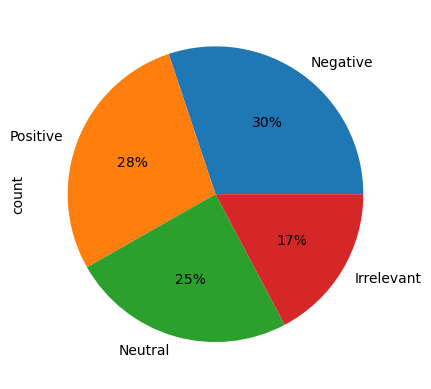

In [16]:
df['sentiment'].value_counts().plot(kind='pie', autopct='%1.0f%%')

# word cloud
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)

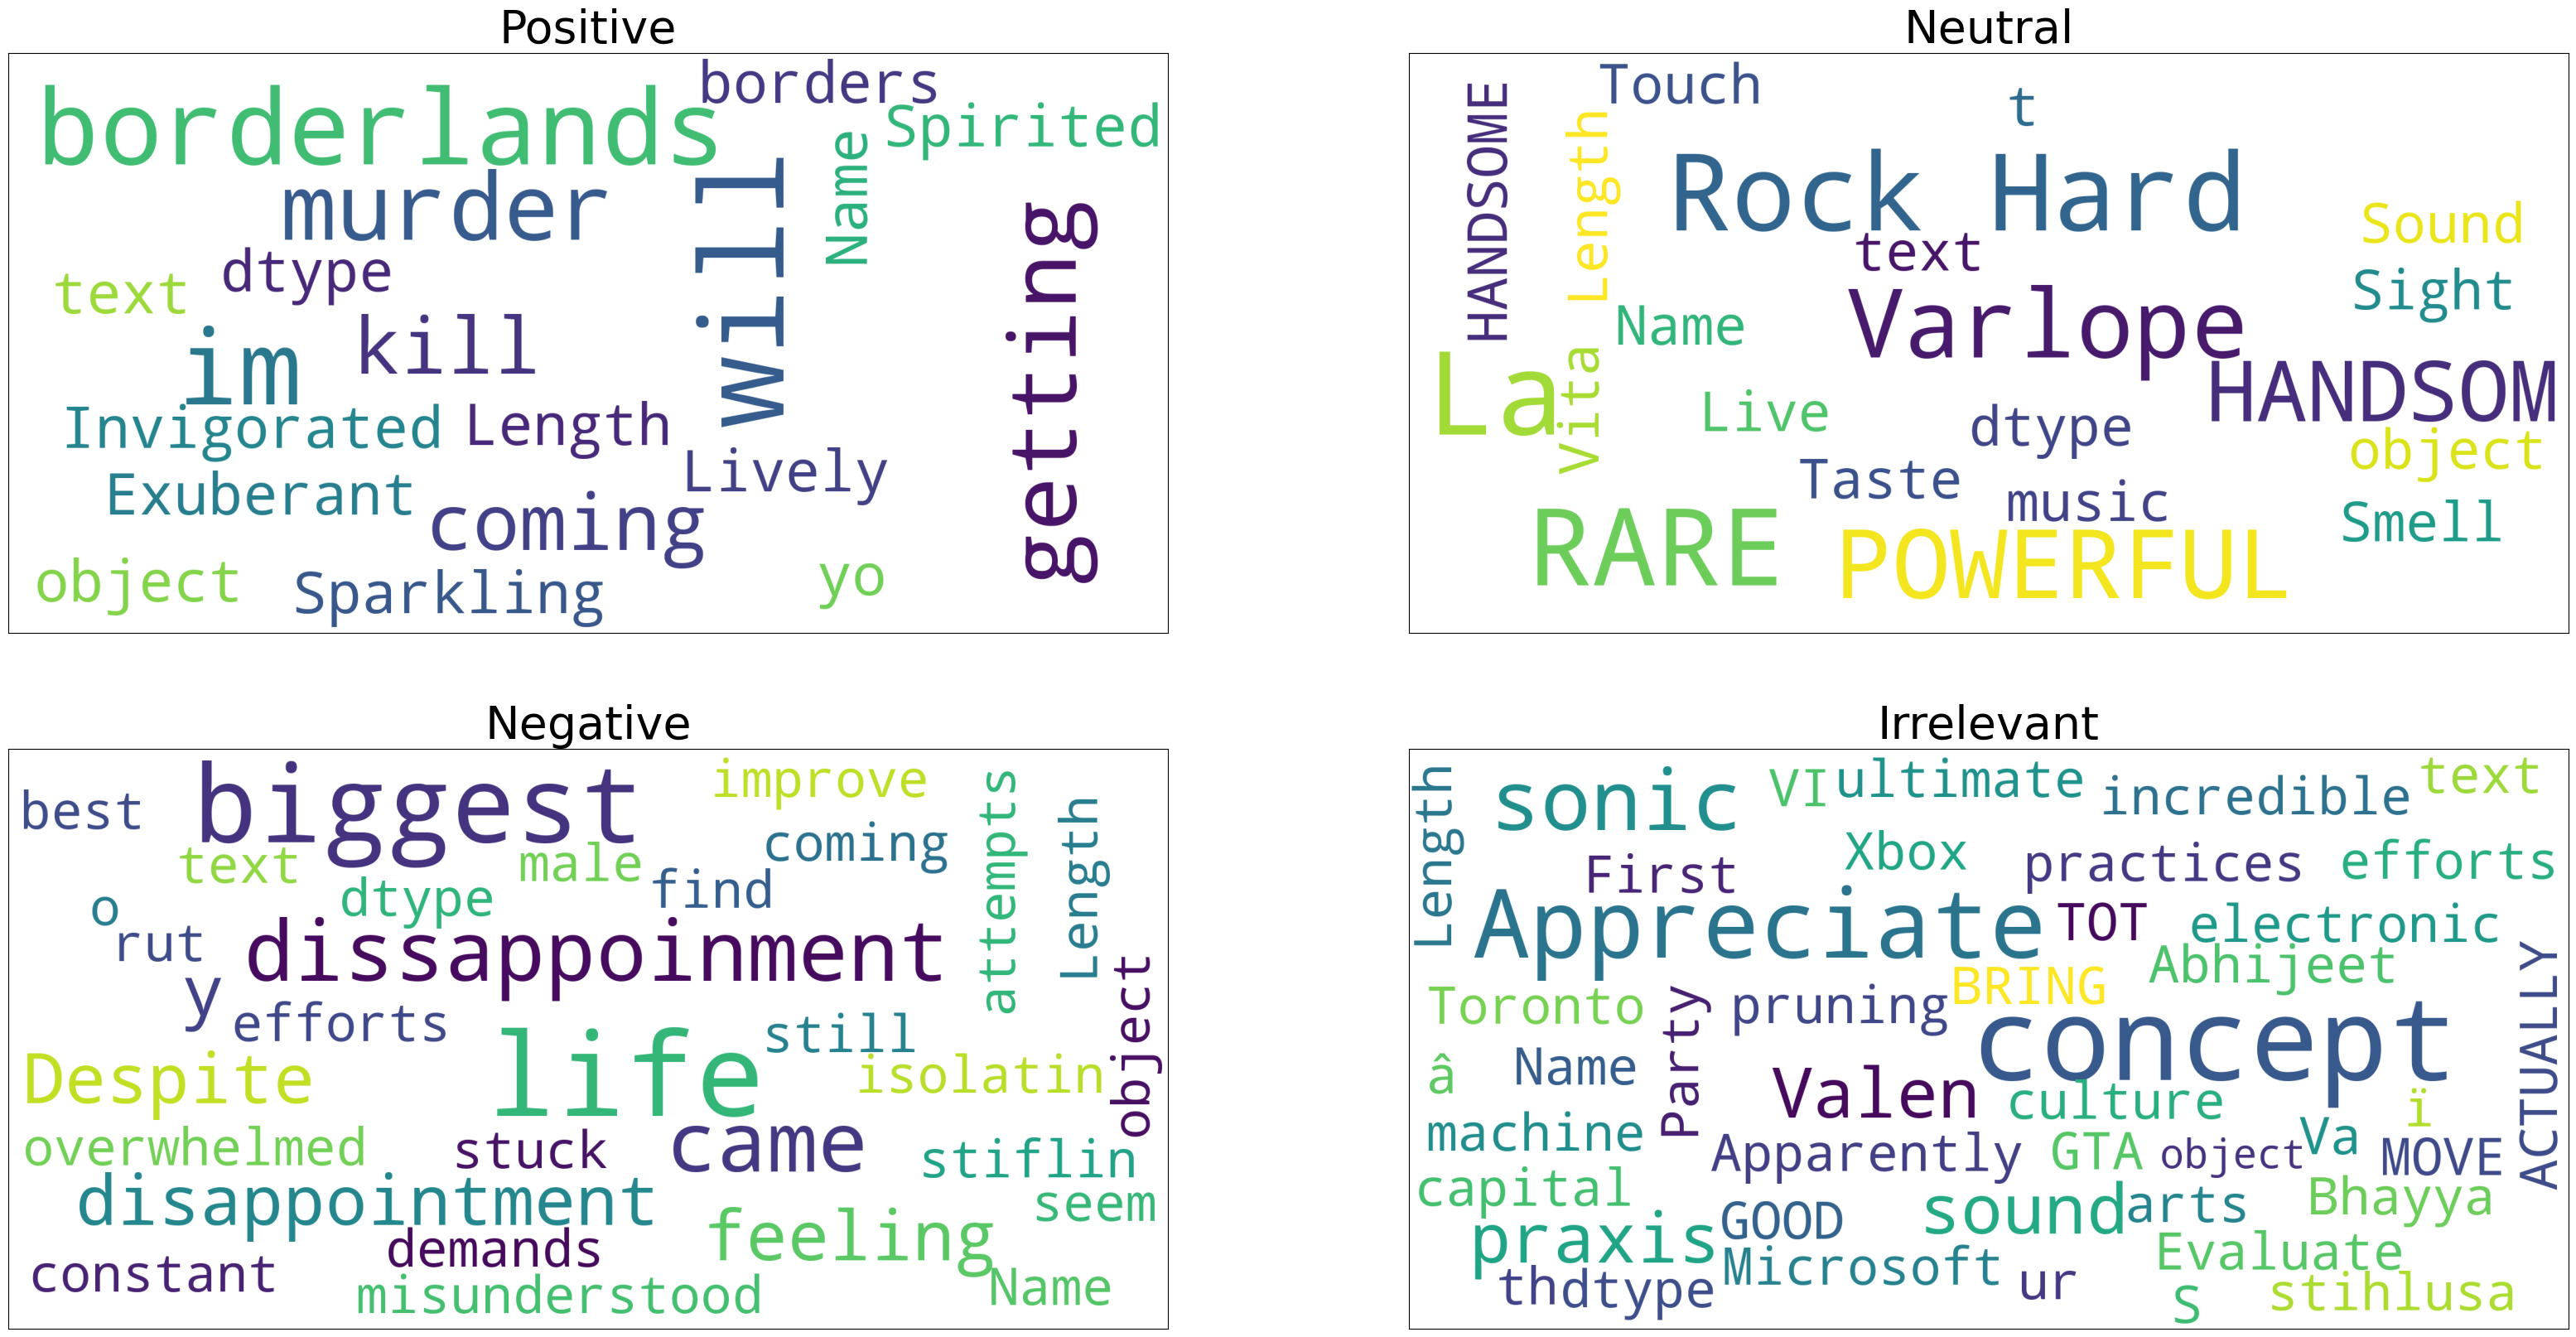

<Figure size 640x480 with 0 Axes>

In [17]:
plt.figure(figsize=(40,20))

for index, col in enumerate(df['sentiment'].unique()):
    plt.subplot(2,2, index+1)
    # print(col)
    df1 = df[df['sentiment']==col]
    data = df1['text']
    wordcloud = WordCloud(background_color='white', stopwords=stopwords, max_words=500, max_font_size=40, scale=5).generate(str(data))
    # fig = plt.figure(figsize=(15,15))
    # plt.axis('off')
    # disable ticks
    plt.xticks([])
    plt.yticks([])
    plt.imshow(wordcloud)
    plt.title(col, fontsize=40)
    
plt.show()
plt.tight_layout()

In [18]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, df.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', df.iloc[i]['text'])
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
  review = ' '.join(review)
  corpus.append(review)

In [19]:
import re

# Define a function to remove URLs using regex
def remove_urls(text):
    return re.sub(r'http\S+', '', text)

def remove_special_chars(text):
    return re.sub(r'[^a-zA-Z\s]', '', text)

def remove_rt(text):
    return text.replace('RT', '')

from bs4 import BeautifulSoup

# Define a function to remove HTML tags using BeautifulSoup
def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

df['text'] = df['text'].apply(lambda x: x.lower())
df['text'] = df['text'].apply(remove_urls)
df['text'] = df['text'].apply(remove_html_tags)
df['text'] = df['text'].apply(remove_special_chars)
df['text'] = df['text'].apply(remove_rt)

C:\Users\Reetika\AppData\Local\Temp\ipykernel_32376\1035691220.py:17: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [20]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['sentiment'], test_size=0.2, random_state=42)

In [21]:
X_train.shape, X_test.shape

((60249,), (15063,))

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

In [23]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['sentiment'], test_size=0.2, random_state=42)


In [24]:
import nltk
from nltk.corpus import stopwords

# Download the stopwords dataset if you haven't already
nltk.download('stopwords')

# Get English stopwords from NLTK and convert to a list
stop_words = stopwords.words('english')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Reetika\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
# Model building
clf = Pipeline([('tfidf', TfidfVectorizer(stop_words=stop_words)), ('clf', RandomForestClassifier(n_estimators=100, n_jobs=-1))])

In [26]:
# Fit the pipeline with training data
clf.fit(X_train, y_train)


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('clf', RandomForestClassifier(n_jobs=-1))])

In [29]:
# Evaluation
predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))


0.9087167230963288


In [30]:
# Classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

  Irrelevant       0.96      0.85      0.90      2627
    Negative       0.93      0.92      0.93      4572
     Neutral       0.92      0.90      0.91      3668
    Positive       0.86      0.94      0.90      4196

    accuracy                           0.91     15063
   macro avg       0.92      0.90      0.91     15063
weighted avg       0.91      0.91      0.91     15063



In [31]:
import pickle

pickle.dump(clf, open('twitter_sentiment.pkl', 'wb'))

In [38]:
clf.predict(['so sick of covid-19, corona virus!! tired of social distancing. tired of it all.'])

array(['Irrelevant'], dtype=object)

In [37]:
clf.predict(['The customer service was terrible, and the product arrived damaged'])

array(['Negative'], dtype=object)

In [36]:
clf.predict(['I received some devastating news today, and Im feeling completely shattered.'])

array(['Negative'], dtype=object)

In [40]:
clf.predict(['i liked this movie very much but its rating were bad'])

array(['Negative'], dtype=object)

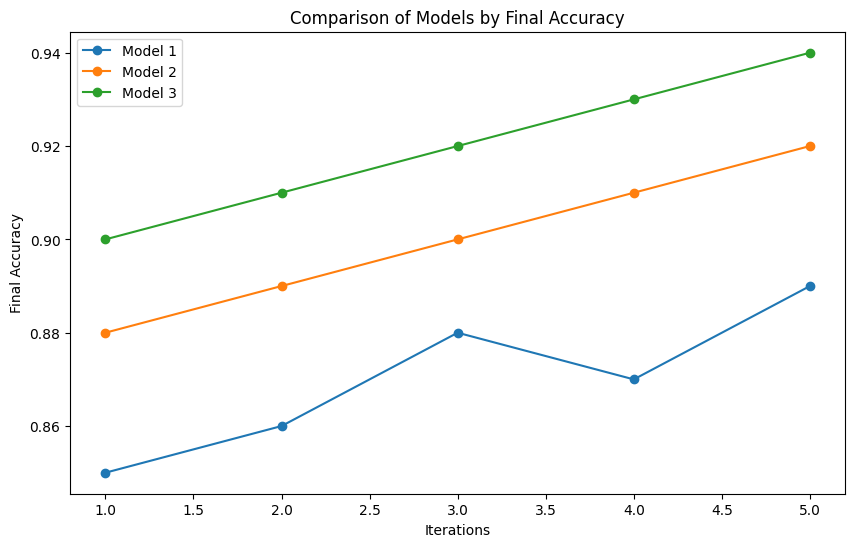

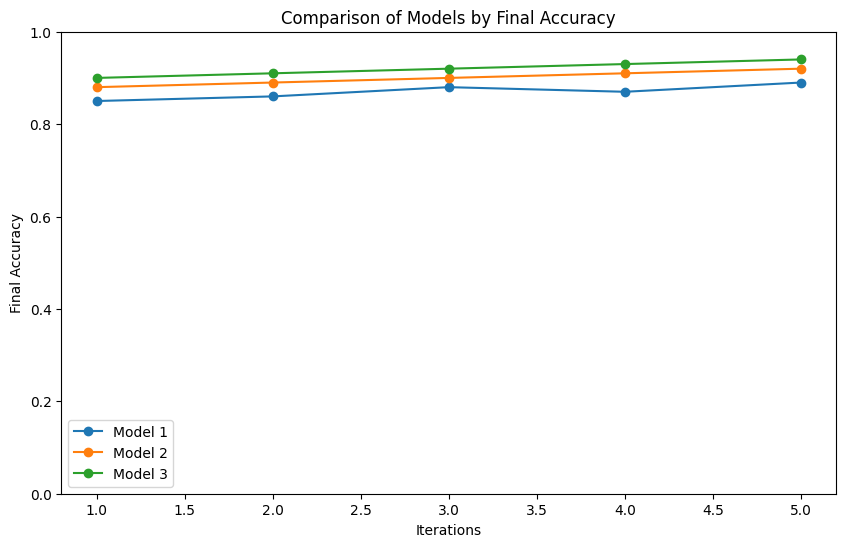